# 0. Import libraries and modules

In [1]:
import bs4
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import requests

import datetime
import os
import csv

# 1. Data collection

#### In this part of the homework, we focus on collecting the data that will be used by the search engine implemented in RQ2

## 1.1 Get the list of places

##### We want to collect the URL associated with the sites listed in the first 400 pages. To do that, we parse throught the pages and retrieve a list of all the links with `a`-tag and class equals to `content-card-place`.
##### Then we open in append mode a txt file in which we write all the elements of the list above created

In [ ]:
url_name = 'https://www.atlasobscura.com' # assign the URL to 'url_name'
for i in range(400): # loop through the pages
    result = requests.get('https://www.atlasobscura.com/places?page={}&sort=likes_count'.format(i+1)) # make a request to the ith web page
    list_soup = bs(result.text) # use Beautiful Soup
    list_places = [x.get('href') for x in list_soup.find_all('a', {'class':'content-card-place'})] # comprehension list of the links of places
    with open ('txt_file_urls.txt','a' ) as f:
        for el in list_places:
            f.write(url_name+el +'\n')
    f.close()

## 1.2 Crawl places

##### We are interested in saving each page in a different HTML file. Each file so created will store the HTML of the places that are listed in the corresponding page.
To do that, firstly we define the function `url_to_text_(urls)` that takes as argument a tuple that contains:
* the index of the page in which a URL is located (from 1 to 18)
* the URL of that place

In [2]:
def url_to_text_(urls):
    
    """ 
    For each url get html and store it in /htmls_page_{page_nr}/{place_name}
    
    Args:
        - urls: a tuple(index_page, URL)
     
    Returns:
        - write write in the folder of the page the HTML of the place
     
    """
    
    i = urls[0] # n° of the page
    url = urls[1].split('\n')[0] # URL of the place
    try:
        os.makedirs('htmls_page_{}'.format(i+1)) # create a directory for the ith page
    except:
        pass
    el = url
    el_name = el.split('.com/places/')[1] # rename the URL in a more clean manner
    result = requests.get(el) # make a request to that URL
    with open('./htmls_page_{}/{}'.format(i+1, el_name), 'w') as wf: # write in the folder of the page...
        wf.write(result.text) #... the HTML of the place
    wf.close()
    return

##### Then, we read the lines of `txt_file_urls.txt`, the file we previously created, and we build a tuple for each line (that represents the URL of a place). Each tuple groups the nuber of page in which the URL is located and the URL itself. Consequently, we create a list of all the tuples, and finally we apply to each tuple the function `url_to_text`

In [34]:
# version 1
if __name__ == '__main__':
    with open ('txt_file_urls.txt', 'r') as urls:
        l = []
        for line in urls:
            l.append(line)
        grouped_l = [l[i:i+18] for i in range(0,len(l), 18)]
        grouped_ln = [[(i, el) for el in group]for i, group in enumerate(grouped_l)]

        grouped_ln_flat = []
        for group in grouped_ln:
            for el in group:
                grouped_ln_flat.append(el)
         
        for el in grouped_ln_flat[:]:
            url_to_text_(el)

In [ ]:
#version 2 to compare with that above 
if __name__ == '__main__':
    with open ('txt_file_urls.txt', 'r') as urls: #reads the txt file
        l = [] # initialize a list
        for line in urls:  
            l.append(line) # list of all urls
        grouped_l = [l[i:i+18] for i in range(0,len(l), 18)] # list of URLS listed for each page
        grouped_ln = [[(i, el) for el in group]for i, group in enumerate(grouped_l)] #list of tuple

        for group in grouped_ln: 
            for el in group:
                url_to_text_(el) # put the HTMLs of the URLs in the corresponding file

## 1.3 Parse downloaded pages

##### In this point we want to create a tsv file for each HTML document. Such files will contain the following information:
1. Place Name (to save as placeName): String.
2. Place Tags (to save as placeTags): List of Strings.
3. Numberof people who have been there (to save as numPeopleVisited): Integer.
4. Number of people who want to visit the place(to save as numPeopleWant): Integer.
5. Description (to save as placeDesc): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
6. Short Description (to save as placeShortDesc): String. Everything from the title and location up to the image (blue frame on the example image).
7. Nearby Places (to save as placeNearby): Extract the names of all nearby places, but only keep unique values: List of Strings.
8. Address of the place(to save as placeAddress): String.
9. Latitud and Longitude of the place's location(to save as placeAlt and placeLong): Floats
10. The username of the post editors (to save as placeEditors): List of Strings.
11. Post publishing date (to save as placePubDate): datetime.
12. The names of the lists that the place was included in (to save as placeRelatedLists): List of Strings.
13. The names of the related places (to save as placeRelatedPlaces): List of Strings.
14. The URL of the page of the place (to save as placeURL):String


![HTML page](https://github.com/lucamaiano/ADM/raw/master/2022/Homework_3/img/last_version_place.png)

##### We define the function `analyse_html` in order to:
* extract the requested information 
* write the information in a tsv file

In [3]:
def analyse_html(page_nr, name, to_tsv = True): 
    """ For page_nr, place_name extract information from html, if NA set ==''
    
        Args:
            - page_nr (int): page number
            - name (str): name of the place
            - to_tsv
            
        Returns:
            - return: write a tsvs file containing all the 14 features
    """
    
    with open('./htmls/htmls_page_{}/{}'.format(page_nr,name), 'r') as f:
        soup = bs(f.read())
    
    try:
        placeName = str(soup.find_all('h1', {'class':'DDPage__header-title'})[0].contents[0])
    except:
        placeName =''

    try:
        a = soup.find_all('a', {'class': 'itemTags__link js-item-tags-link'})
        placeTags = [el.get('href').split('/categories/')[1] for el in a]
    except:
        placeTags =''

    try:
        nrs = soup.find_all('div', {'class':'title-md item-action-count'})[:2]
        numPeopleVisited = int(nrs[0].get_text())
    except:
        numPeopleVisited=''

    try:
        nrs = soup.find_all('div', {'class':'title-md item-action-count'})[:2]
        numPeopleWant = int(nrs[1].get_text())
    except:
        numPeopleWant = ''

    try:
        place_desc = soup.find_all('div', {'class': 'DDP__body-copy'})
        text = ''.join([el.get_text() for el in place_desc])
        placeDesc = text.replace('\n', '').replace('\xa0', '')
    except:
        placeDesc=''

    try:
        placeShortDesc = soup.find_all('h3', {'class': 'DDPage__header-dek'})[0].contents[0]
    except:
        placeShortDesc=''

    try:
        side = soup.find_all('div', {'class':'DDPageSiderailRecirc__item-title'})
        placeNearby = [s.get_text() for s in side]
    except:
        placeNearby = ''

    try:
        a=soup.find_all('address', {'class':'DDPageSiderail__address'})[0]
        placeAdress = a.find('div').get_text(separator = ' ').split('\n')[0]
    except:
        placeAdress = ''

    try:
        b=soup.find('div', {'class':'DDPageSiderail__coordinates js-copy-coordinates'})
        lat,lng = b.get('data-coordinates').split(',')
        placeAlt = float(lat)
        placeLong = float(lng)
    except:
        placeAlt = ''
        placeLong = ''


    try:
        contributors = soup.find_all('div', {'class': 'ugc-editor-icons'})
        href = [c.findChildren('a')[0].get('href') for c in contributors]
        #alt = [c.findChildren('img')[0].get('alt') for c in contributors]
        placeEditors = [h.split('/users/')[1] for h in href]
    except:
        placeEditors = ''

    try:    
        date = soup.find_all('div', {'class': 'DDPContributor__name'})
        dt_string = date[0].get_text()
        format = "%B %d, %Y"
        placePubDate = datetime.datetime.strptime(dt_string, format)
    except:
        placePubDate= ''

    try:
        pot = soup.find_all('div', {'class':'CardRecircSection__title'})
        lists = [o for o in pot if o.text == 'Appears in 1 List'][0]
        pl = lists.find_all_next('h3', {'class':'Card__heading --content-card-v2-title js-title-content'})
        placeRelatedLists = [el.find('span').text for el in pl]
    except:
        placeRelatedLists = ''

    try:
        pot = soup.find_all('div', {'class':'CardRecircSection__title'})
        rel = [o for o in pot if o.text == 'Related Places'][0]
        pl = rel.find_all_next('div', {'class':'Card__action-btns vue-js-been-there-everywhere-place'})
        placeRelatedPlaces = [p.get('data-place-title') for p in pl]
    except:
        placeRelatedPlaces=''

    try:
        placeURL = 'https://www.atlasobscura.com/places/'+name
    except:
        placeURL = ''
        
    info = [placeName, placeTags, numPeopleWant, numPeopleVisited, placeDesc, placeShortDesc, placeNearby, placeAdress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedLists, placeRelatedPlaces, placeURL]
   
    if to_tsv:
        with open ('tsvs_page_{}/{}.tsv'.format(i+1, name), 'w') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(info)
            

##### Then, we loop over the pages and for each place we write the information in a tsv file using the above implemented function (`analyse_html`)

In [ ]:
for i in range(400):
    els = os.listdir('./htmls/htmls_page_{}'.format(i+1))
    os.makedirs('tsvs_page_{}'.format(i+1))

    for name in els:
        analyse_html(i+1, name)

# 2. Search Engine

#### This part of the Homework deals with creating two search engines. The search engines will be build in subsection *2.1* and *2.2*

## 2.1 Conjunctive query

####

### 2.1.1 Create your index!

In [19]:
# Import libraries and modules
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

##### Firstly, we define a function `description_to_stems`

In [21]:
def description_to_stems(desc):
    """ function that takes a description and:
        - converts the words to lower case
        - removes stopwords
        - removes punctutaion
        - stems the words
        - removes words with len()<=1
        
    Args:
        - descr (str): the description of a place
        
    Returns:
    
        
    """
    
    lower = desc.lower()
    
    stopword = set(stopwords.words('english'))

    word_tokens = RegexpTokenizer('\s', gaps=True).tokenize(lower)

    regex = r"[!\"#\$%&\“\”\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]"
    no_stops = [re.sub(regex, '', w) for w in word_tokens if not w in stopword]

    stemmer = SnowballStemmer('english')
    stems = [stemmer.stem(w) for w in no_stops if len(stemmer.stem(w))>1]

    words = stems
    return words

In [ ]:
# looping pages and places.tsv; read the description and pass to the preprocessing function description_to_stems()
# sequence of words returned that are stored in a dictionary, that maps str -> nr of elements added before (lenght of dict)

vocabulary = {}

for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r', encoding = "utf-8") as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:# if i ==4][0]
                desc = row[4]
                words = set(description_to_stems(desc))
                
                for word in words:
                    if word not in vocabulary.keys():
                        vocabulary[word] = int(len(vocabulary))

In [ ]:
# saving the vocabulary dictionary to csv

with open("vocabulary.csv", "w") as voc_f:
    w = csv.writer(voc_f)
    for key, val in vocabulary.items():
        w.writerow([key, val])

In [512]:
# preprocessing the descriptions, map documents words to index and generate a dict
# of index -> page_index/documentname.tsv
mapping = {}

for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r') as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:# if i ==4][0]
                desc = row[4]
                words = set(description_to_stems(desc))
                for word in words:
                    idx = vocabulary[word]
                    try:
                        mapping[idx].append(str(i+1)+'/'+name) 
                    except:
                        mapping[idx] = [str(i+1)+'/'+name]

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 207.97it/s]


In [458]:
# saving the term_id to document_name dictionary to csv

with open("termid_document.csv", "w") as map_f:
    w = csv.writer(map_f)
    for key, val in mapping.items():
        w.writerow([key, val])

In [441]:
inp = str(input())

museum american horror


In [454]:
# given a string input with blank space each word is mapped to the vocabulary index, which is then mapped to
# the matching documents by the termid_document dict. 
# the intersection of matching document sets is determined and the document names returned

def docs_matching_query(inp):
    sub_matches = []
    for el in inp.split(' '):
        try:
            idx = vocabulary[el]
            subm = mapping[idx]
            sub_matches.append(subm)
        except:
            pass    
    try:
        both = set(sub_matches[0])
        for sub_query in sub_matches:
            both = both.intersection(sub_query)
    except:
        both = ''
        
    return both


In [488]:
# print data of the matching documents 
import pandas as pd

docs = docs_matching_query(inp)
dfs = []
for el in docs:
    i, name = el.split('/')
    with open ( './tsvs/tsvs_page_{}/{}'.format(int(i), name), 'r') as f:
        tsv_reader = csv.reader(f, delimiter="\t")
        for row in tsv_reader:# if i ==4][0]
            new_df = pd.DataFrame([row[0], row[4], row[14]]).T
            dfs.append(new_df)

df = pd.concat(dfs)
df.columns=['placeName', 'placeDesc', 'placeURL']
df

,placeName,placeDesc,placeURL
0,Murals of Maxo Vanka,Created in protest against industrial capitali...,https://www.atlasobscura.com/places/murals-of-...
0,Grave of Ed Gein,"While not technically a serial killer, the ter...",https://www.atlasobscura.com/places/plainfield...
0,Buckhorn Saloon and Museum,Drink a beer whilst you admire stuffed cougars...,https://www.atlasobscura.com/places/buckhorn-s...
0,PsychoBarn,If you’re casually strolling down Piccadilly a...,https://www.atlasobscura.com/places/psychobarn


# 2.2?

In [570]:
import numpy as np
from collections import Counter
import pandas as pd

In [496]:
# weights for each word in vocabulary, term_id -> weight_term

weights = {}
n = 7200

for key in mapping.keys():
    weights[key] = np.log(n/len(mapping[key]))

In [521]:
# mapping terms to list of (file_name, tf-idf)
# tf-idf = tfj * wj = tfj * log(n/nj) n = 7200

mapping_tfidf = {}
for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r') as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:
                desc = row[4]
                words = description_to_stems(desc)
                ln = len(words)
                
                counter = Counter(words)
                for word in counter:
                    idx = vocabulary[word]
                    freq = counter[word]/ln*weights[idx] # == tf
                    try:
                        mapping_tfidf[idx].append( (str(i+1)+'/'+name, freq) )
                    except:
                        mapping_tfidf[idx] = [ (str(i+1)+'/'+name, freq) ]

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 187.91it/s]


In [523]:
# writing freq_mapping to csv

with open("termid_document_freq.csv", "w") as map_ffreq:
    w = csv.writer(map_ffreq)
    for key, val in mapping_tfidf.items():
        w.writerow([key, val])

In [526]:
# testing 

inp = str(input())

matches = docs_matching_query(inp)

american flower


In [527]:
matches

{'124/atocha-station-tropical-garden.tsv',
 '126/fenway-victory-gardens.tsv',
 '189/plainfield-cemetery.tsv',
 '199/medicine-rocks-state-park.tsv',
 '254/felicity-california-center-of-the-world.tsv',
 '27/bannermans-castle.tsv',
 '310/carnivorous-plants-at-the-huntington-gardens.tsv',
 '322/hare-krishna-tree.tsv',
 '353/coltsville.tsv',
 '396/cole-porter-s-piano.tsv',
 '68/harvard-museum-of-natural-history.tsv',
 '78/casina-delle-civete.tsv',
 '79/mueller-sunflowers.tsv',
 '91/dumbarton-oaks.tsv',
 '91/ethel-m-botanical-cactus-garden.tsv'}

In [563]:
# taking input_query, list of matching documents, int k
# read matching document_description, count occurence of the words that are in the input_query/len(description)

# since we only need the relative similarity between matches, the dimensions of the input are irrelevant
# the cosine similarity is ~ to vector_of_words_in_match/len(vector_of_words_in_match)
# since all dimensions but the words of the input query are orthogonal we can look only at the values in 
# that dimension and normalize by the length of the whole vector_of_words_in_match==len(description)

def cos_rel_similarst(inp, matches, k):
    for match in matches:
        i, name = match.split('/')
        with open ( './tsvs/tsvs_page_{}/{}'.format(int(i), name), 'r') as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:
                desc = description_to_stems(row[4])# if i ==4][0]
                ln = len(desc)
                counter = Counter(desc)
                sim = sum(counter[sub_query] for sub_query in inps)/ln
                if len(k_matches) < k:
                    k_matches[sim] = ([row[0], row[4], row[14]])
                else:
                    if sim > min( list(k_matches.keys()) ):
                        min_key = min( list(k_matches.keys()) )
                        k_matches.pop(min_key)
                        k_matches[sim] = ([row[0], row[4], row[14]])

    df = pd.DataFrame.from_dict(k_matches, orient='index')
    df = df.reset_index(drop=True)
    df['Similarity'] = list (k_matches.keys() )

    df.columns=['placeName', 'placeDesc', 'placeURL', 'Similarity']
    df = df.sort_values(by='Similarity', ascending = False)
    return df

In [564]:
cos_rel_similarst(inp, matches, 3)

,placeName,placeDesc,placeURL,Similarity
1,Atocha Station Tropical Garden,The winding paths and many benches within this...,https://www.atlasobscura.com/places/atocha-sta...,0.024631
0,Fenway Victory Gardens,"While World War II battles raged overseas, bac...",https://www.atlasobscura.com/places/fenway-vic...,0.019608
2,Mueller SunFlowers,"On a certain stretch of I-35 near Austin, Texa...",https://www.atlasobscura.com/places/mueller-su...,0.018987


# 7. Theoretical Question

### **Introduction**

#### The question asked to implement three algorithms to solve the following problem:

> *"Given n students and their m grades, rank the students in order of highest average grade and, in case of parity, rank them in alphabetical order."*

### 1. The 3 Algorithms

In [3]:
# Input sets with which to test the algorithms
file1 = 'Ex1_Applicants.txt' # first given input
file2 = 'Ex2_Applicants.txt' # second given input
file3 = 'Ex3_Applicants.txt' # a third input consctructed by the first adding the case that two student have the same grade
file = 'ApplicantsInfo.txt'

#### **a. The first algorithm: a Naive Approach**

##### This is the first algorithm that came to our mind. The algorithm performs the following operations:
1. open the input file and parse information accross its lines
2. compute the average grade for each student and build a list associating names with average grades
3. sort, in the desired order, the list
4. create a new txt file containing the ranking of the students

##### First, we define the function `bubbleSort` that sorts, in a very natural and easy way, the elements of an array by repeatedly swapping adjacent elements that are out of order.
##### In our version of bubblesort, we order a lists of name-grade pairs by bubbling out pairs with the smallest grades (and once again, in case of parity, the alphabetic order is preserved).

##### Secondly, we write the `Naive` algorithm that opens up the input txt file, extracts information from that file (i.e. grades, number of grades and students), builds a list of name-grade pairs, leverages the `bubbleSort` algorithm, and writes a txt file containing the students' ranking. 

In [1]:
def bubbleSort(items):
    for i in range (0,len(items)): # loop through the list
        for j in range(0, len(items)-i-1): # an inner loop is used to compare the element of the outer loop with the other elements of the list
            if items[j][1] < items[j + 1][1]: # if any element is greater than the element of the outer loop, swap the values...
                items[j], items[j + 1] = items[j + 1], items[j]
            elif items[j][1] == items[j + 1][1]: # if the average grade is equal...
                if items[j][0] > items[j + 1][0]: # ,following alphabetical order, 
                    items[j], items[j + 1] = items[j + 1], items[j] # swap the pairs
            else:
                pass
    return items


def Naive(file):
    
    items =[] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() # creates a list of strings contained in each line
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines: 
            line = line.strip().split() # a list of all the characters of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item) # append each pair to the list
    bubbleSort(items) # leverage bubblesort()
    f.close() # close file

                    
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            # write each item on a new line
            f.write(str(ele[0])+ ' ' + str(ele[1])) # write a line containing the name and average grade of a particular student
            f.write('\n') # close file
    f.close() # close file
    return


In [5]:
Naive(file1)

##### We tested the algorithm thus built on the input files and we found that it does its job. So, it is likely correct but it may be very inneficient.
##### Indeed the algorithm takes too much time when `ApplicantsInfo.txt` is passed as argument.

#### **b. The second Algorithm:**


##### The first algorithm, though correct, is not capable to go through all the information contained in 'ApplicantsInfo.txt'. For this reason we have to come out with an algorithm more efficient than that above.
##### A good starting point is to analyze the inefficiencies of the 'Naive' algorithm, and fix them. We noticed that the sorting algorithm used by `Naive` is not the most efficient one. 
##### Thus, we can address this issue by building another sorting algorting that works better than `bubblesort`. The second algorithm, called `MS_version`, leverages on a *merge sort* type of algorithm.

##### From theory, we know that merge sort:
1. divides the problem of sorting into smaller subproblems of the same instance of the main problem,
2. solves these subproblems recursively (or if their sizes are small enough it solves the subproblems in a straightforward manner),
3. combines the solutions to the subproblems into the solution for the original problem

##### We can then use the `mergeSort` procedure in our new algorithm.

In [213]:
def mergeSort(items):
    if len(items) > 1: # compute the length of the list
        mid = len(items)//2 # find the median of the array
        L = items[:mid] # put the left part of the items in a list
        R = items[mid:] # put the right part in another one
        mergeSort(L) # recall 'mergeSort' on the left part
        mergeSort(R) # recall 'mergeSort' on the right part
        left_count = right_count = k = 0 # initialize 3 variable
        # Copy data to temp arrays L[] and R[]
        while left_count < len(L) and right_count < len(R): # while loop to iterate from i to min(len(L),len(R))
            if L[left_count][1] > R[right_count][1]: # order by descending gpa
                items[k] = L[left_count] 
                left_count += 1 # increment left_count
            elif L[left_count][1] == R[right_count][1]: # if two student have the same grade
                if L[left_count][0] < R[right_count][0]: #...follow alphabetical order
                    items[k] = L[left_count]
                    left_count += 1 # increment left_count
                else:
                    items[k] = R[right_count]
                    right_count += 1 # increment right_count
            else:
                items[k] = R[right_count]
                right_count += 1 # increment right_count
            k += 1
        while left_count < len(L): # Checking if any element was left over
            items[k] = L[left_count] # if so, assign element to the remaining positions on the list
            left_count += 1
            k += 1
        while right_count < len(R): # Checking if any element was left over
            items[k] = R[right_count] # if so, assign element to the remaining positions on the list
            right_count += 1
            k += 1
    return (items)


def MS_version(file):
    
    items =[] # initialize a list that will store lists of name-gpa pairs
    with open(file) as f:
        ''' parse the txt file '''
        
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = mergeSort(items)
    f.close()
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            # write each item on a new line
            f.write(str(ele[0])+ ' ' + str(ele[1])) # write a line containing the name and average grade of a particular student
            f.write('\n')
    f.close()
    return        

#### **c. The third Algorithm:**

##### With the `MS_version` we are able to process `ApplicationsInfo.txt`.
##### From theory, we know that merge sort is a reliable sorting method that performs particularly well with big data. However, the main drawback of merge sort is that it uses a lot of memory before merging the elements.
##### So, we intend to propose an alternative agorithm called `QS_version` that leverages upon a quick sort algorithm.

##### According to the theory, A quick sort algorithm works by selecting a 'pivot' element from the array and partitioning the other elements into two sub-arrays, according to whether they are less than or greater than the pivot. We can split this algorithm in three steps:
1. reorder its elements, while determining a point of division, so that all elements with values less than the pivot come before the division, while all elements with values greater than the pivot come after it; elements that are equal to the pivot can go either way. Since at least one instance of the pivot is present, most partition routines ensure that the value that ends up at the point of division is equal to the pivot, and is now in its final position (but termination of quicksort does not depend on this, as long as sub-ranges strictly smaller than the original are produced).
2. Recursively apply the quicksort to the sub-range up to the point of division and to the sub-range after it, possibly excluding from both ranges the element equal to the pivot at the point of division. (If the partition produces a possibly larger sub-range near the boundary where all elements are known to be equal to the pivot, these can be excluded as well.)


In [214]:
def partition(items, low, high):
    ''' '''
  
    #Choose the rightmost element...
    pivot1 = items[high][1] # ...for grades
    pivot2 = items[high][0] # and for names
    
    i = low - 1 # Pointer
    for j in range(low, high): # Loop through all elements and compare each element with pivot
        if items[j][1] > pivot1: # If the grade is greater than pivot1...
            i = i + 1 # after increasing the pointer
            (items[i], items[j]) = (items[j], items[i]) # ...swap the element at i with element at j
        elif items[j][1] == pivot1: # If grade equals pivot1
            if items[j][0] < pivot2: # and name smaller than pivot2...
                i = i + 1 # after increasing the pointer
                (items[i], items[j]) = (items[j], items[i]) # ...swap the element at i with element at j

    # Swap the pivot element with the greater element specified by i
    (items[i + 1], items[high]) = (items[high], items[i + 1])
  
    # Return the position from where partition is done
    return i + 1
  
# Function to perform quicksort
  
def quickSort(items, low, high):
    if low < high:

        pi = partition(items, low, high)
  
        quickSort(items, low, pi - 1)  # Recursive call on the left of pivot

        quickSort(items, pi + 1, high) # Recursive call on the right of pivot
        
    return (items)


def QS_version(file):
    
    items = [] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = quickSort(items,0, n-1)
    f.close()
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            # write each item on a new line
            f.write(str(ele[0])+ ' ' + str(ele[1])) # write a line containing the name and average grade of a particular student
            f.write('\n')
    f.close()
    return    

### 2. The time complexities of 'Naive', 'MS_version', and 'QS_version'.

##### The time complexity of each algorithm is given by the time complexity of the sorting algorithm plus the time complexity of the remaining lines of the algorithm. Since we already know, from theory, the complexity of the sorting algorithms, our job is limited to find the runtime of the other lines of code. 

#### Naive

##### Let be `n` the number of students and `m` the number of grades.
##### We know that bubble sort has a time complexity of $O(n^2)$. `BubbleSort` is in fact used to sort a list by passing through it $n*n$ times, where n is the size of the list.
##### Now, let's deep into the remaining chunks of code. Werember that the algorithm:
* reads the input file by performing:
    1. an outer loop of `n` iterations 
    2. an inner loop of `m` iterations
* writes the output file by performing:
    3. a single loop of `n` iterations
    
Thus, the complexity of the code excluding the sorting algorithm is $O(n*m) + O(n) -> O(n*m)$
##### Putting everything together, we derive that the total complexity is $O(n*m)+ O(n^2) -> O(n^2)$

#### MS_version

##### The complexity of merge sort is $O(n*log n)$. 
##### The complexity of the code excluding the sorting algorithm is $O(n*m)$
##### Thus, the total complexity is $O(n*m) + O(n*log n) -> O(n*logn)$

#### QS_version

##### We know that the complexity of quick sort is $O(n^2)$. This is surely true even though we must say that the expected running time of this algorithm is in the order of $O(n*logn)$. 
##### Anyhow, the total complexity is $O(n*m) + O(n^2)-> O(n^2)$

### 3. Evaluate the running time 

##### We are interested in comparing the runtime of these three algorithms. One way to do it is to define a function`getime` that computes how long it takes for a given algorithm to process the input file.

In [215]:
#evaluate runtime
def getime(algo,file):
    import time
    st = time.time() 
    algo(file)
    et = time.time()
    return (round(et-st,3))

In [216]:
MS = getime(MS_version,file) # time of MS_version

In [217]:
MS

17.738

In [358]:
QS = getime(QS_version,file) # time of QS_version

In [359]:
QS

17.567

In [105]:
N = getime(Naive,file) # time of Naive

##### Now, we can plot the results.

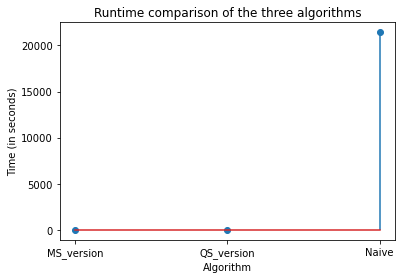

In [111]:
import matplotlib.pyplot as plt
x = ['MS_version', 'QS_version', 'Naive']
y = [MS, QS, N]
plt.title('Runtime comparison of the three algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Time (in seconds)')
plt.stem(x, y, use_line_collection=True)
plt.show()

##### From the graph above, it emerges that `Naive` is the absolute loser while `MS_version` and `QS_version` are two candidates. In order to choose between the two we need to get deep into analysing these two algorithms. 

##### From the second point of RQ7, we know that the complexity of `QS_version` is expected to be in the order of that of `MS_version`. So this time we prevent from using the `getime` function.
##### That is because `getime` outuputs a result that fluctuates, and so we cannot simply rely on that result.
##### Thus, in order to be more certain of which algorithm is faster we use the `%timeit` magic function with `32` repetitions. This way, we smooth some a of the variability inherent in the previous results.



In [375]:
%timeit -r 32 MS_version(file) # runtime for MS

13.4 s ± 656 ms per loop (mean ± std. dev. of 32 runs, 1 loop each)


In [374]:
%timeit -r 32 QS_version(file) # runtime for QS

13.1 s ± 752 ms per loop (mean ± std. dev. of 32 runs, 1 loop each)


##### Then, we plot the results.

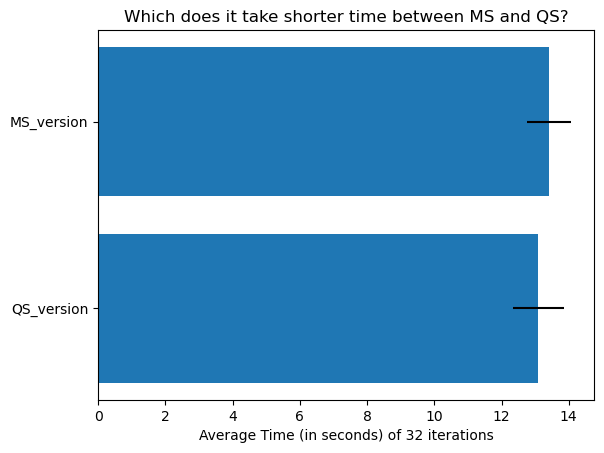

In [389]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
algorithms = ('MS_version', 'QS_version')
y_pos = np.arange(len(algorithms))
x = np.array([13.4,13.1])
error = np.array([0.656,0.752])

ax.barh(y_pos, x, xerr=error, align='center')
ax.set_yticks(y_pos, labels=algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Time (in seconds) of 32 iterations')
ax.set_title('Which does it take shorter time between MS and QS?')

plt.show()

##### Answer: There is no clear winner. However, since, as we previously said, `quicksort` sorts a list of items *in place* (to wit, with no need of additional storage space) we tend to prefer `QS_version` over `MS_version`

### 5. The MapReduce Algorithm

In [ ]:
#### Map each input line to
#### Reduce each grade with the sum of all the 1's
#### We need a map function and reduce function.
#### The map function takes a block of data as argument
#### and produce key-value pairs as outputs.
#### The Reducer takes the output of the Mapper as argument
#### and aggregates those intermediate data  
#### into a smaller set of key-value pairs 
#### which is the final output.

##### MapReduce algorithm consists of two very important tasks:
* `Map`
* `Reduce`
##### Mapper class functions with taking the input, tokenizing it, mapping it, and finally sorting it. Then, the output of the Mapper class is transferred as an input to Reducer class, where the searching of matching pairs is done, followed by reducing.

The sorting algorithm is implemented by MapReduce to sort the output key-value pairs from the mapper with respect to their keys.
Sorting methods are applied within the mapper class.
In the Shuffle and Sort phase, after tokenizing the values in the mapper class, the user-defined(Context) class gets the matching valued keys as a collection.
The RawComparator class helps the Mapper class to collect similar key-value pairs (intermediate keys),and sort them.
Before the final values are produced to the Reducer, the set of intermediate key-value pairs for a given Reducer is automatically sorted by Hadoop to form key-values (K2, {V2, V2, …}).



In [342]:
def mapper(items):
    map_dict = {}
    for item in items:
        if item[1] not in list(map_dict.keys()):
            map_dict.setdefault(item[1], [])
            map_dict[item[1]].append(item[0]) 
        else:
            map_dict[item[1]].append(item[0])
        
    return map_dict


def shuffler(map_dict):
    from sortedcontainers import SortedDict
    shuff_dict = SortedDict(map_dict)
    return shuff_dict

def reducer (shuff_dict):
    reduc_dict = {value: key for key in shuff_dict for value in shuff_dict[key]}
    return reduc_dict


def mapReduce_sort(items):
    map_dict = mapper(items)
    shuff_dict = shuffler (map_dict)
    reduc_dict = reducer (shuff_dict)
    return reduc_dict
        

def mapReduce(file):
    
    items = [] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = mapReduce_sort(items)
    f.close()
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        items = list(items.items())
        for i in range(len(items)-1,-1,-1): # loop through d_items
            # write each item on a new line
            f.write(str(items[i][0])+ ' ' + str(items[i][1])) # write a line containing the name and average grade of a particular student
            f.write('\n')
    f.close()
    return 

    

In [376]:
%timeit -r 32 mapReduce(file)

12.8 s ± 527 ms per loop (mean ± std. dev. of 32 runs, 1 loop each)


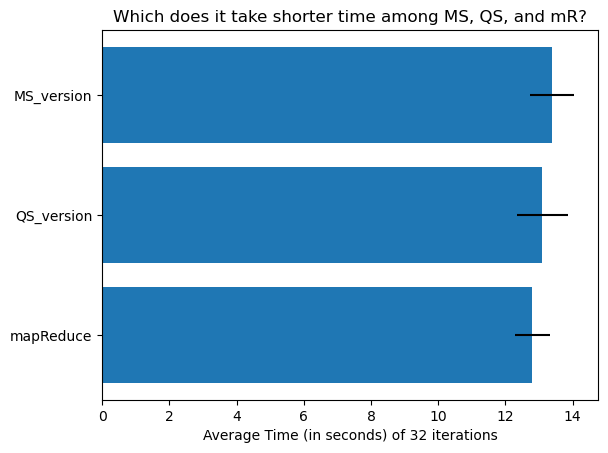

In [388]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
algorithms = ('MS_version', 'QS_version','mapReduce')
y_pos = np.arange(len(algorithms))
x = np.array([13.4,13.1,12.8])
error = np.array([0.656,0.752,0.527])

ax.barh(y_pos, x, xerr=error, align='center')
ax.set_yticks(y_pos, labels=algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Time (in seconds) of 32 iterations')
ax.set_title('Which does it take shorter time among MS, QS, and mR?')

plt.show()

##### Answer: 